# HW 3: Network Embedding, Image Recognition, and Text Classification

<div class="alert alert-block alert-warning">Each assignment needs to be completed independently. Never ever copy others' work (even with minor modification, e.g. changing variable names). Anti-Plagiarism software will be used to check all submissions. </div>

In this assignment, we'll have three experiments:
- GitHub network analysis through node embedding or graph neural networks
- Image classification: Diagnose COVID-19 by CT images
- Text classification: Let's redo the news classification task of HW #2 using CNN


<font color='red'>Warnings:</font>

- If you're new to deep learning, you may find this assignment **challenging**.
- To help you start, read lab materials carefully and make sure you understand each example in the lab.
- Recommend you to use Colab for this assignment. GPU would be preferred, but not necessary.
- Give yourself enough time, <u>at least three days</u>. Don't expect that you can complete this assignment within one day. 
- Feel free to reach out to me or our TA if you have any question.



At last, if you can successfully complete this assignment, you should feel proud to claim that you have managed to conquer the beginning stage of deep learning study and enter the intermediate stage!

## Q1: GitHub network analysis: Predict whether the GitHub user is a web or a machine learning developer.

Dataset:
- The dataset can be downloaded from https://snap.stanford.edu/data/github-social.html
- I have split nodes into train and test for you. Please use `musae_git_target_train_test_split.csv` for nodes, labels, and train/test split.



Requirements:
- You'll only need to predict node class by network adjacency matrix (i.e., `musae_git_edges.csv`) and node labels (i.e., `musae_git_target_train_test_split.csv`). No other features are needed.
- You'll need to derive node representations by Node2Vec or GNN
- Then you create a linear classification model using the node representations as input. For this part, you can reuse you model and training script in HW2
- The nodes have been split into training and test subsets (the `test` column indicates if a node is for train or test). Please use the given test nodes for testing.
- Your target is to achieve `at least 84% accuracy` on the test subset. 

In [1]:
import networkx as nx
import pandas as pd
from node2vec import Node2Vec
import json
import numpy as np
import torch
import torch.nn as nn
import time
from PIL import Image
import glob
import os
import torchvision
import torchvision.transforms as transforms
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch_geometric.data import InMemoryDataset, Data
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import torchtext
import keras
from keras.datasets import reuters
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re

In [2]:
KCG = nx.read_edgelist("git_web_ml/musae_git_edges.csv", delimiter=",")
KCG.remove_node('id_1')
KCG.remove_node('id_2')
nx.info(KCG)

'Graph with 37700 nodes and 289003 edges'

In [3]:
# Data Preparation 
eg = nx.to_scipy_sparse_matrix(KCG).tocoo()
eg_idx = torch.stack([torch.tensor(eg.row),torch.tensor(eg.col)],dim=0).long()
id_dic = {int(item): idx for idx, item in enumerate(KCG.nodes)}

In [4]:
# read target
data = pd.read_csv("git_web_ml/musae_git_target_train_test_split.csv")
data.head()

,id,name,ml_target,test
0,0,Eiryyy,0,False
1,1,shawflying,0,False
2,2,JpMCarrilho,1,True
3,3,SuhwanCha,0,False
4,4,sunilangadi2,1,False


In [5]:
train = data[data['test']==False]
X_train, X_val, y_train, y_val = train_test_split(train['id'], train['ml_target'], 
                                                  test_size=0.2, stratify=train['ml_target'])
X_test = data[data['test']]['id']
y_test = data[data['test']]['ml_target']

print(f'Train: positives: {sum(y_train)}, total: {len(X_train)}')
print(f'Eval: positives: {sum(y_val)}, total: {len(X_val)}')
print(f'Test: positives: {sum(y_test)}, total: {len(X_test)}')

Train: positives: 6233, total: 24128
Eval: positives: 1558, total: 6032
Test: positives: 1948, total: 7540


In [6]:
# Define datat class
train_id = [id_dic[i] for i in X_train]
val_id = [id_dic[i] for i in X_val]
test_id = [id_dic[i] for i in X_test]

class _dataset(Dataset):
    
    def __init__(self, X, y):
        super(_dataset, self).__init__()
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.from_numpy(np.array(list(y))).float()
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

_train = _dataset(train_id, y_train)
_val = _dataset(val_id, y_val)
_test = _dataset(test_id, y_test)

In [7]:
class GCN(nn.Module):
    
    def __init__(self):
        super(GCN, self).__init__()
        self.emb = nn.Embedding(KCG.number_of_nodes(), 233)
        self.conv1 = GCNConv(233, 107)
        self.conv2 = GCNConv(107, 61)
        self.conv3 = GCNConv(61, 31)
        self.conv4 = GCNConv(31, 1)
        self.reg = nn.Sequential(nn.ReLU(), nn.Dropout(0.13))
            
    def forward(self, node_index, edge_index):
        embeddings = self.emb(node_index)
        out = self.conv1(embeddings, edge_index)
        out = self.reg(out)
        out = self.conv2(out, edge_index)
        out = self.reg(out)
        out = self.conv3(out, edge_index)
        out = self.reg(out)
        out = self.conv4(out, edge_index)
        
        return nn.Sigmoid()(out)

In [8]:
def train_model(model, train_set, val_set, test_id, device, batch_size,
                lr=0.0005, epochs=50):
    
    history = {'train_loss': [], 'train_acc': [], 'eval_loss': [], 'eval_acc': []}

    model = model.to(device)
    Loss = nn.BCELoss().to(device)
    op = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(val_set, batch_size=batch_size)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        train_acc = 0
        eval_loss = 0
        eval_acc = 0
        
        for a, b in train_loader:
            out = model(torch.arange(KCG.number_of_nodes()).to(device), eg_idx.to(device))[a].view(-1)
            label = b.to(device)
            
            acc = (torch.round(out)==label).float().mean().item()
            loss = Loss(out, label)
            train_loss += loss.item()
            train_acc += acc
        
            op.zero_grad()
            loss.backward()
            op.step()

            
        model.eval()
        with torch.no_grad():
            for a, b in eval_loader:
                out = model(torch.arange(KCG.number_of_nodes()).to(device), eg_idx.to(device))[a].view(-1)
                label = b.to(device)
                
                acc = (torch.round(out)==label).float().mean().item()
                loss = Loss(out, label)
                eval_loss += loss.item()
                eval_acc += acc
                
        train_loss = train_loss/len(train_loader)
        train_acc = train_acc/len(train_loader)
        eval_loss = eval_loss/len(eval_loader)
        eval_acc = eval_acc/len(eval_loader)            
              
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(eval_loss)
        history['eval_acc'].append(eval_acc)    

        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {format(train_loss, ".8f")} \t Train Accuracy: {format(train_acc*100, ".3f")} %')
        print(f'Eval Loss: {format(eval_loss, ".8f")} \t Eval Accuracy: {format(eval_acc*100, ".3f")} %')
        
    print(f'\nTraining complete! Spent time: {format(time.time()-start, ".5f")} seconds\n')
    
    with torch.no_grad():
        test_out = model(torch.arange(KCG.number_of_nodes()).to(device), eg_idx.to(device))[test_id].view(-1)
        test_label = torch.from_numpy(np.array(list(y_test))).float().to(device)
        test_acc = (torch.round(test_out)==test_label).float().mean().item()

    print(classification_report(test_label.cpu(), torch.round(test_out).cpu()))
    print(f'\nAccuracy on test subset: {format(test_acc*100, ".3f")} %')
    
    return history

In [9]:
# Train model
model = GCN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 3e-4
epochs = 7
batch_size = 233

hist = train_model(model, _train, _val, test_id, device, batch_size, lr, epochs)

Training start!
Epoch: 1/7
Train Loss: 0.60153166 	 Train Accuracy: 71.364 %
Eval Loss: 0.53911586 	 Eval Accuracy: 74.178 %
Epoch: 2/7
Train Loss: 0.45771847 	 Train Accuracy: 78.088 %
Eval Loss: 0.38800946 	 Eval Accuracy: 83.627 %
Epoch: 3/7
Train Loss: 0.36044459 	 Train Accuracy: 85.161 %
Eval Loss: 0.36934926 	 Eval Accuracy: 84.691 %
Epoch: 4/7
Train Loss: 0.33761236 	 Train Accuracy: 86.140 %
Eval Loss: 0.36556661 	 Eval Accuracy: 84.809 %
Epoch: 5/7
Train Loss: 0.32652752 	 Train Accuracy: 86.672 %
Eval Loss: 0.36236076 	 Eval Accuracy: 84.951 %
Epoch: 6/7
Train Loss: 0.31497462 	 Train Accuracy: 87.250 %
Eval Loss: 0.36411514 	 Eval Accuracy: 84.840 %
Epoch: 7/7
Train Loss: 0.30538584 	 Train Accuracy: 87.623 %
Eval Loss: 0.36587102 	 Eval Accuracy: 84.854 %

Training complete! Spent time: 32.92426 seconds

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      5592
         1.0       0.75      0.61      0.67      1948

    acc

## Q2: Diagnose COVID-19 by CT images 

Please first download the CT images
- `COVID-19 CT scans`: https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_COVID.zip. In total, there are 349 images.
- `Non-COVID-19 Scans`: https://github.com/UCSD-AI4H/COVID-CT/blob/master/Images-processed/CT_NonCOVID.zip. There are 397 images in total.

This dataset may be a little small for CNN models. Let's just use this dataset to practice CNN models.

### Q2.1. Data Preprocessing 

- Refer to CNN labs to read the image files and create datasets.
- For each class, use 60% images for training, 20% for validation, and 20% for testing. `The split has been created for you`.
- Create a Dataset class so that you can preprocess images and generate mini-batches for training. Since the CT scans are grayscale (only 1 channel), you can transform all images to grayscale. `(1 point dedicated to this step)`

In [2]:
random_seed = 124
np.random.seed(random_seed)

torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [2]:
# Load images and split data into train/eval/test subsets

pos_files = [Image.open(f) for f in glob.glob(os.path.join('COVID/CT_COVID','*.*'))]
neg_files = [Image.open(f) for f in  glob.glob(os.path.join('COVID/CT_NonCOVID','*.*'))]

images = pos_files + neg_files
labels = np.array([1]*len(pos_files)+[0]*len(neg_files))

images_tv, images_test, y_tv, y_test  = train_test_split(images, labels, shuffle=True, test_size=0.2,
                                                         random_state=123, stratify = labels)
images_train, images_val, y_train, y_val  = train_test_split(images_tv, y_tv, shuffle=True, stratify = y_tv,
                                                             test_size=0.25, random_state=123)

In [12]:
print(len(y_train), len(y_val), len(y_test))

print(y_train.sum(), y_val.sum(), y_test.sum())

447 149 150
209 70 70


In [13]:
class CT_Dataset(Dataset):
    
    def __init__(self, X, y):
        super(CT_Dataset, self).__init__()
        self.X = torch.stack(list(map(lambda x: transforms.ToTensor()
                (transforms.Resize((384,512))(transforms.Grayscale()(x))), X)))
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
train_ = CT_Dataset(images_train, y_train)
val_ = CT_Dataset(images_val, y_val)
test_ = CT_Dataset(images_test, y_test)

### Q2.2. Build Model 

- Create a CNN models with appropriate layers of `Convolution`, `MaxPooling2D`, and `Dense` layers. Use appropriate activation functions for these layers.
- Since this dataset is small, it may be easily get overfitted. Leverage `Dropout` or other regularization techniques to fight overfitting
- Configure your model with appropriate optimizer and loss function.

In [40]:
class Convnet(nn.Module):
    
    def __init__(self):
        super(Convnet, self).__init__()
        self.cv = nn.Sequential(
            nn.Conv2d(1, 32, 5), # (n, 32, 380, 508)
            nn.ReLU(),
            nn.MaxPool2d(5), # (n, 32, 76, 101)
            nn.Conv2d(32, 32, 3), # (n, 32, 74, 99)
            nn.ReLU(),
            nn.MaxPool2d(3), # (n, 32, 24, 33)
            nn.Conv2d(32, 32, 2), # (n, 32, 23, 32)
            nn.ReLU(),
            nn.MaxPool2d(2), # (n, 32, 11, 16)
            nn.Flatten())
        self.net = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(32*176, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid())   
            
    def forward(self, x):
        return self.net(self.cv(x))

### Q2.3. Fit your model 

- Define a function to train the model until it converges. You should use the `evaluation dataset` to control the training process such that the model is not overfitted.
- Plot the loss and accuracy of the model over the training and validation data
- Test the model using `test dataset` and show the test accuracy. You need to achieve a `test accuracy of 70% or higher`



In [4]:
def train_model(model, train_dataset, eval_dataset, test_dataset, device, 
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'train_acc': [], 'eval_loss': [], 'eval_acc': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = model.to(device)
    Loss = nn.BCELoss().to(device)
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        train_acc = 0
        eval_loss = 0
        eval_acc = 0
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            acc = (torch.round(out)==y).float().mean().item()
            loss = Loss(out, y)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            train_acc += acc
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X).squeeze(-1)
                acc = (torch.round(out)==y).float().mean().item()
                loss = Loss(out, y)
                eval_loss += loss
                eval_acc += acc  
                
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        eval_loss = (eval_loss/len(eval_loader)).item()
        eval_acc = eval_acc/len(eval_loader)  
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['eval_loss'].append(eval_loss)
        history['eval_acc'].append(eval_acc)     
        
        print(f'Epoch: {epoch+1}/{epochs}')
        print(f'Train Loss: {format(train_loss, ".8f")} \t Train Accuracy: {format(train_acc*100, ".3f")} %')
        print(f'Eval Loss: {format(eval_loss, ".8f")} \t Eval Accuracy: {format(eval_acc*100, ".3f")} %')
        
    print(f'\nTraining complete! Spent time: {format(time.time()-start, ".5f")} seconds\n')
    
    test_acc = 0
    pred = []
    y_true = []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X).squeeze(-1)
            acc = (torch.round(out)==y).float().mean().item()
            test_acc += acc  
            pred.append(torch.round(out).cpu())
            y_true.append(y.cpu())

    test_acc = test_acc/len(test_loader)   
    print(f'Test Accuracy: {test_acc*100} %\n')
    print(classification_report(torch.cat(y_true), torch.cat(pred).cpu()))
    
    return history

In [51]:
model = Convnet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
epochs = 30
batch_size = 16

hist = train_model(model, train_, val_, test_, device, 
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!
Epoch: 1/30
Train Loss: 0.69399327 	 Train Accuracy: 48.274 %
Eval Loss: 0.69143212 	 Eval Accuracy: 52.125 %
Epoch: 2/30
Train Loss: 0.68947786 	 Train Accuracy: 53.199 %
Eval Loss: 0.68927741 	 Eval Accuracy: 52.125 %
Epoch: 3/30
Train Loss: 0.68081003 	 Train Accuracy: 55.923 %
Eval Loss: 0.68237168 	 Eval Accuracy: 52.125 %
Epoch: 4/30
Train Loss: 0.66272420 	 Train Accuracy: 60.625 %
Eval Loss: 0.67968452 	 Eval Accuracy: 53.625 %
Epoch: 5/30
Train Loss: 0.63173193 	 Train Accuracy: 65.074 %
Eval Loss: 0.66308403 	 Eval Accuracy: 64.375 %
Epoch: 6/30
Train Loss: 0.60771245 	 Train Accuracy: 66.176 %
Eval Loss: 0.64463115 	 Eval Accuracy: 65.000 %
Epoch: 7/30
Train Loss: 0.59174180 	 Train Accuracy: 70.060 %
Eval Loss: 0.68824160 	 Eval Accuracy: 59.125 %
Epoch: 8/30
Train Loss: 0.55659527 	 Train Accuracy: 69.836 %
Eval Loss: 0.66737914 	 Eval Accuracy: 61.000 %
Epoch: 9/30
Train Loss: 0.51823580 	 Train Accuracy: 74.479 %
Eval Loss: 0.63596213 	 Eval Accuracy: 63.

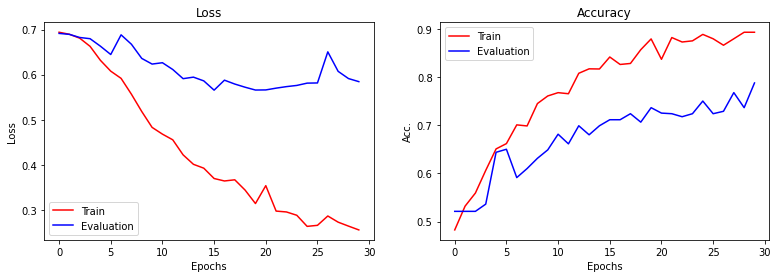

In [53]:
f, ax = plt.subplots(1,2, figsize=(13, 4))

ax[0].set_title('Loss')
ax[0].set(xlabel='Epochs', ylabel='Loss')
ax[0].plot(hist['train_loss'], label = 'Train', color='r')
ax[0].plot(hist['eval_loss'], label = 'Evaluation', color='b')    
ax[0].legend()

ax[1].set_title('Accuracy')
ax[1].set(xlabel='Epochs', ylabel='Acc.')
ax[1].plot(hist['train_acc'], label = 'Train', color='r')
ax[1].plot(hist['eval_acc'], label = 'Evaluation', color='b')    
ax[1].legend();

### Q2.4. (Bonus) Using pretrained industry model 

Since we have a small dataset, a thought is that perhaps we can improve the performance using pretrained industry models such as VGG 16.

- Decide which pretrained model you'd like to use
- Think about whether you'd like to fine tune some layers
- Show your analysis: 
  - Do you think the pretrained model helps?
  - Why or why not

In [5]:
vgg = torchvision.models.vgg16()
vgg.load_state_dict(torch.load('C:/Users/DevNMor/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))

# vgg = torchvision.models.vgg16(pretrained=True)

<All keys matched successfully>

In [6]:
class VGG_Dataset(Dataset):
    
    def __init__(self, X, y):
        super(VGG_Dataset, self).__init__()
        self.X = torch.stack(list(map(lambda x: torch.cat([transforms.ToTensor()
                (transforms.Resize((224,224))(transforms.Grayscale()(x)))]*3), X)))
#         self.X = torch.cat([vgg.features(i) for i in DataLoader(xx, batch_size=16)])
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
train_ = VGG_Dataset(images_train, y_train)
val_ = VGG_Dataset(images_val, y_val)
test_ = VGG_Dataset(images_test, y_test)


class VGG_FT(nn.Module):
    
    def __init__(self):
        super(VGG_FT, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(128*16*196, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid())   
            
    def forward(self, x):
        return self.net(vgg.features[:10].cuda()(x))

In [8]:
model_pret = VGG_FT()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 1e-4
epochs = 20
batch_size = 2

hist = train_model(model_pret, train_, val_, test_, device, 
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!
Epoch: 1/20
Train Loss: 1.03930700 	 Train Accuracy: 60.491 %
Eval Loss: 0.50892627 	 Eval Accuracy: 74.667 %
Epoch: 2/20
Train Loss: 0.21455070 	 Train Accuracy: 93.080 %
Eval Loss: 0.56337470 	 Eval Accuracy: 76.000 %
Epoch: 3/20
Train Loss: 0.10955859 	 Train Accuracy: 95.759 %
Eval Loss: 0.83136660 	 Eval Accuracy: 68.667 %
Epoch: 4/20
Train Loss: 0.03835611 	 Train Accuracy: 99.107 %
Eval Loss: 0.62010866 	 Eval Accuracy: 75.333 %
Epoch: 5/20
Train Loss: 0.03224700 	 Train Accuracy: 99.554 %
Eval Loss: 0.78604573 	 Eval Accuracy: 69.333 %
Epoch: 6/20
Train Loss: 0.01970856 	 Train Accuracy: 99.330 %
Eval Loss: 0.70868045 	 Eval Accuracy: 78.667 %
Epoch: 7/20
Train Loss: 0.01353349 	 Train Accuracy: 99.554 %
Eval Loss: 0.71786565 	 Eval Accuracy: 78.000 %
Epoch: 8/20
Train Loss: 0.02996666 	 Train Accuracy: 99.554 %
Eval Loss: 0.72861683 	 Eval Accuracy: 76.000 %
Epoch: 9/20
Train Loss: 0.03055570 	 Train Accuracy: 98.438 %
Eval Loss: 1.40291989 	 Eval Accuracy: 71.

#### _*I don't think this really help. Here I use the previous 10 layers of VGG-16 as the pre-trained model for feature engineering of our data. However, its performance is no much better than our customized model.*_
#### _*Firstly, our data size is too small. According to a paper by Tibshirani, under the circumstances that the sample size is small, when our parameters' number gets greater, the test loss will first increase, then decrease. While my computer cannot tolerate that great numbers of parameters (a huge model), I'm still in the first stage, which is typically named as "overfitting". In fact, the model has done feature extraction for a classification task with 1000 labels (identifying various objects and animals), obviously way too much for our data. Hence, our data size doesn't allow VGG-16 to fully perform its great ability.*_
#### _*The second reson here is somehow personal. For me, using pre-trained model / embeddings is convinient, but is actually a trade off between computation resources of computers and accuracy, or efficiency of certain indicators. Since my computer is not that super so far, I don't think it really fit for the data for now.*_

## Q3: News Classification by CNN 

In HW #2, You have used linear layers to classify text. This time, let's use CNN model to see if the performance can be improved.



### Q3.1 Data Processing 

Since the embedding layer expects a sentences with uniform length, you need to pad or truncate the sentences to the same length. Properly decide the maximum length of the sentence so that most of sentences are kept intact after processing. However, do not set the maximum length too big, which reduces the computational efficiency.

In [3]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# show the sizes training/testing samples 
len(train_data)
len(test_data)

# show an example from the training dataset
print(train_data[10])

# retrieve the mapping from words to indices
word_index = reuters.get_word_index()

# reverse mapping
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index[i - 3] for i in train_data[0] if (i-3) in reverse_word_index])

decoded_newswire

[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


'said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [4]:
# preprocess text, determine vocabulary and max length of each document,  pad or truncate text

stop_words = stopwords.words('english')
stop_idx = [word_index[i] for i in stop_words if i in word_index]

def get_list(data):
    tk_list = []
    voc = []
    for i in data:
        temp = [j-3 for j in i if j>=4 and j-3 not in stop_idx and not reverse_word_index[j-3].isdigit()]
        tk_list.append(temp)
        voc += temp
    voc = list(set(voc))
    return voc, tk_list

voc_train, tk_train = get_list(train_data)
voc_test, tk_test = get_list(test_data)

voc_dic = {item: idx+1 for idx, item in enumerate(voc_train)}

def word2idx(token_list, voc_dic):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token in voc_dic:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx

train_id = word2idx(tk_train, voc_dic)
test_id = word2idx(tk_test, voc_dic)

In [5]:
# Define Dataset Class

class dataset_(Dataset):
    
    def __init__(self, X, y, max_len=1024):
        super(dataset_, self).__init__()
        pad = [i[:max_len] + [0]*(max_len-len(i[:max_len])) for i in X]
        self.X = torch.tensor(pad, dtype=torch.int32)
        self.y = torch.tensor(y, dtype=torch.long)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)

train_ = dataset_(train_id, train_labels)
test_ = dataset_(test_id, test_labels)

### Q3.2 Define the model 

- Your model should contain the follow layers:
    - Embedding (Note, you are not required to use pretrained word vector in the embedding layer)
    - Convolution
    - MaxPool
    - Flatten, Concatenate, Dropout if needed
    - Dense


- Carefully choose the following hyperparameters:
  - Max. sentence length
  - Embedding dimension
  - Filter sizes and number of filters 
- Use appropriate activate functions for all layers

In [66]:
class cnn_text(nn.Module):
    
    def __init__(self, voc_size=len(voc_train)+1):
        super(cnn_text, self).__init__()
        
        self.emb = nn.Embedding(voc_size, 128, 0)
        self.uni = nn.Sequential(
            nn.Conv1d(128, 64, 1), 
            nn.ReLU(),
            nn.MaxPool1d(1024), 
            nn.Flatten())
        self.bi = nn.Sequential(
            nn.Conv1d(128, 64, 2), 
            nn.ReLU(),
            nn.MaxPool1d(1023), 
            nn.Flatten())
        self.tri = nn.Sequential(
            nn.Conv1d(128, 64, 3), 
            nn.ReLU(),
            nn.MaxPool1d(1022), 
            nn.Flatten())    
        self.net = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64*3, 128),
            nn.ReLU(),
            nn.Linear(128, 46))
        
    def forward(self, x):
        x = self.emb(x)
        x = torch.cat([self.uni(x.transpose(-2, -1)), 
                       self.bi(x.transpose(-2, -1)), 
                       self.tri(x.transpose(-2, -1))], dim=1)
        return self.net(x)

### Q3.3. Train the model

- Fit the model, plot the training curve on training and testing datasets

- You can certainly reuse your training function from HW #2.

- Analysis:
  - Do you think the CNN can achieve better performance, compared with the linear model in HW #2?
  - Why do you think CNN can do better?

In [69]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = model.to(device)
    Loss = nn.CrossEntropyLoss().to(device)
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            acc = (out.argmax(1)==y).float().mean().item()
            loss = Loss(out, y)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            train_acc += acc
            
        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                acc = (out.argmax(1)==y).float().mean().item()
                loss = Loss(out, y)
                
                test_loss += loss
                test_acc += acc  
                
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        test_loss = (test_loss/len(test_loader)).item()
        test_acc = test_acc/len(test_loader)  
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)     
        
        if not (epoch+1)%5:
            print(f'Epoch: {epoch+1}/{epochs}')
            print(f'Train Loss: {format(train_loss, ".8f")} \t Train Accuracy: {format(train_acc*100, ".3f")} %')
            print(f'Test Loss: {format(test_loss, ".8f")} \t Test Accuracy: {format(test_acc*100, ".3f")} %')
        
    print(f'\nTraining complete! Spent time: {format(time.time()-start, ".5f")} seconds\n')
    
    return history

In [70]:
# train model and plot learning curves

model = cnn_text()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 3e-4
epochs = 50
batch_size = 128

hist = train_model(model, train_, test_, device, 
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!
Epoch: 5/50
Train Loss: 1.44221532 	 Train Accuracy: 66.246 %
Test Loss: 1.39128804 	 Test Accuracy: 67.786 %
Epoch: 10/50
Train Loss: 1.10032022 	 Train Accuracy: 73.280 %
Test Loss: 1.09566367 	 Test Accuracy: 75.033 %
Epoch: 15/50
Train Loss: 0.92838842 	 Train Accuracy: 76.801 %
Test Loss: 0.97144538 	 Test Accuracy: 76.675 %
Epoch: 20/50
Train Loss: 0.80520099 	 Train Accuracy: 79.779 %
Test Loss: 0.90190148 	 Test Accuracy: 78.287 %
Epoch: 25/50
Train Loss: 0.72897696 	 Train Accuracy: 81.562 %
Test Loss: 0.84840804 	 Test Accuracy: 80.095 %
Epoch: 30/50
Train Loss: 0.67540848 	 Train Accuracy: 82.408 %
Test Loss: 0.82497859 	 Test Accuracy: 80.841 %
Epoch: 35/50
Train Loss: 0.59204119 	 Train Accuracy: 84.157 %
Test Loss: 0.80395925 	 Test Accuracy: 81.145 %
Epoch: 40/50
Train Loss: 0.55448496 	 Train Accuracy: 84.904 %
Test Loss: 0.78120935 	 Test Accuracy: 81.651 %
Epoch: 45/50
Train Loss: 0.52433962 	 Train Accuracy: 86.041 %
Test Loss: 0.78704262 	 Test Accur

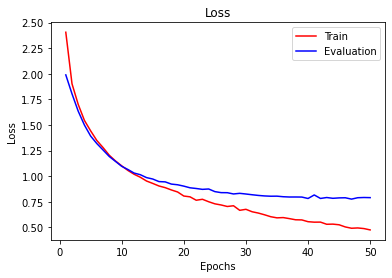

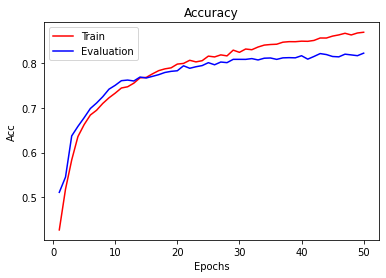

In [71]:
epochs = range(1, len(hist['train_loss']) + 1)

plt.plot(epochs, hist['train_loss'], 'r-', label='Train')
plt.plot(epochs, hist['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, hist['train_acc'], 'r-', label='Train')
plt.plot(epochs, hist['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

#### _*As seen, the test accuracy here has easily exceeded the delicately-tuned results of our last assignment, generally demonstrating the superiority of CNN to linear model.*_
#### _*The main reason for that, in my opinion, should first be attibuted to the different features we use in two models.*_
#### _*For the last assignment, I think we've only used the count vectors (similar to TF-IDF matrix) for each document, which focuses on the overall frequencies of each word in each document and across different documents. This would be pretty comfortable when the problem is not that complicated or requires a quick and simple solution. While for CNN model, what we've done is much more complicated. Instead of using the count vectors, we randomly initialize embeddings for each word and plug them into each document, making the model much more word-specified than before.*_
#### _*In addition, we check the unigrams, bigrams and trigrams in a document by applying convolution model with different kernel sizes, while previously in the linear model, we only consider the effect of unigrams, which might not be enough to explain the sentiments inside a document.*_

### Q3.4 (Bonus) Pretrained Wore Vectors 

It's a common practice to use pretrained word vectors to initialize the embedding layer paramters and then fine tune the embedding layer during model training.

- Train word vector by yourself or find pretrained word vectors
- Initialize the embedding layer with the word vectors
- You can freeze the embedding layer or fine tune the layer
- Fit the model to see what strategy can further improve the training performance

In [28]:
vec = torchtext.vocab.GloVe(name='6B', dim=100)

voc_emb = list(set(voc_train + voc_test))
initial = torch.zeros((len(voc_emb)+1, 100))
miss = []
for i in range(len(voc_emb)):
    try:
        initial[i+1] = vec[reverse_word_index[voc_emb[i]]]
    except:
        miss.append(voc_emb[i])

voc_dic = {item: idx+1 for idx, item in enumerate(voc_emb)}

def word2idx_new(token_list, voc_dic):
    
    token_idx = []
    for sent in token_list:
        sent_list = []
        for token in sent:
            if token not in miss:
                idx = voc_dic[token]
            else:
                idx = 0
            sent_list.append(idx)
        token_idx.append(sent_list)

    return token_idx

train_new_id = word2idx_new(tk_train, voc_dic)
test_new_id = word2idx_new(tk_test, voc_dic)

train_new_ = dataset_(train_new_id, train_labels)
test_new_ = dataset_(test_new_id, test_labels)

In [57]:
class cnn_pretrained(nn.Module):
    
    def __init__(self):
        super(cnn_pretrained, self).__init__()
        
        self.emb = nn.Sequential(
            nn.Embedding.from_pretrained(initial, freeze=True, padding_idx=0),
            nn.Linear(100, 128))
        self.uni = nn.Sequential(
            nn.Conv1d(128, 64, 1), 
            nn.ReLU(),
            nn.MaxPool1d(1024), 
            nn.Flatten())
        self.bi = nn.Sequential(
            nn.Conv1d(128, 64, 2), 
            nn.ReLU(),
            nn.MaxPool1d(1023), 
            nn.Flatten())
        self.tri = nn.Sequential(
            nn.Conv1d(128, 64, 3), 
            nn.ReLU(),
            nn.MaxPool1d(1022), 
            nn.Flatten())    
        self.net = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64*3, 128),
            nn.ReLU(),
            nn.Linear(128, 46))
        
    def forward(self, x):
        x = self.emb(x)
        x = torch.cat([self.uni(x.transpose(-2, -1)), 
                       self.bi(x.transpose(-2, -1)), 
                       self.tri(x.transpose(-2, -1))], dim=1)
        return self.net(x)

In [58]:
def train_model(model, train_dataset, test_dataset, device, 
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = model.to(device)
    Loss = nn.CrossEntropyLoss().to(device)
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        train_acc = 0
        test_loss = 0
        test_acc = 0
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            acc = (out.argmax(1)==y).float().mean().item()
            loss = Loss(out, y)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            train_acc += acc
            
        model.eval()
        with torch.no_grad():
            for X, y in test_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                acc = (out.argmax(1)==y).float().mean().item()
                loss = Loss(out, y)
                
                test_loss += loss
                test_acc += acc  
                
        train_loss = (train_loss/len(train_loader)).item()
        train_acc = train_acc/len(train_loader)
        test_loss = (test_loss/len(test_loader)).item()
        test_acc = test_acc/len(test_loader)  
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)     
        
        if not (epoch+1)%5:
            print(f'Epoch: {epoch+1}/{epochs}')
            print(f'Train Loss: {format(train_loss, ".8f")} \t Train Accuracy: {format(train_acc*100, ".3f")} %')
            print(f'Test Loss: {format(test_loss, ".8f")} \t Test Accuracy: {format(test_acc*100, ".3f")} %')
        
    print(f'\nTraining complete! Spent time: {format(time.time()-start, ".5f")} seconds\n')
    
    return history

In [59]:
model = cnn_pretrained()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 3e-4
epochs = 50
batch_size = 128

hist = train_model(model, train_new_, test_new_, device, 
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!
Epoch: 5/50
Train Loss: 1.29567969 	 Train Accuracy: 68.359 %
Test Loss: 1.27895439 	 Test Accuracy: 68.170 %
Epoch: 10/50
Train Loss: 1.01255178 	 Train Accuracy: 74.975 %
Test Loss: 1.04321766 	 Test Accuracy: 74.469 %
Epoch: 15/50
Train Loss: 0.85459316 	 Train Accuracy: 78.232 %
Test Loss: 0.91381401 	 Test Accuracy: 77.362 %
Epoch: 20/50
Train Loss: 0.75067532 	 Train Accuracy: 80.829 %
Test Loss: 0.85691297 	 Test Accuracy: 78.874 %
Epoch: 25/50
Train Loss: 0.67304701 	 Train Accuracy: 82.741 %
Test Loss: 0.81094009 	 Test Accuracy: 80.110 %
Epoch: 30/50
Train Loss: 0.61238545 	 Train Accuracy: 84.403 %
Test Loss: 0.78844333 	 Test Accuracy: 80.552 %
Epoch: 35/50
Train Loss: 0.57101566 	 Train Accuracy: 85.393 %
Test Loss: 0.77632183 	 Test Accuracy: 81.318 %
Epoch: 40/50
Train Loss: 0.53530234 	 Train Accuracy: 86.480 %
Test Loss: 0.76836085 	 Test Accuracy: 81.839 %
Epoch: 45/50
Train Loss: 0.49093822 	 Train Accuracy: 87.559 %
Test Loss: 0.78160155 	 Test Accur

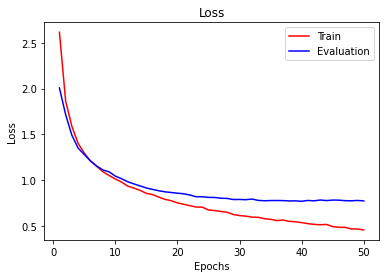

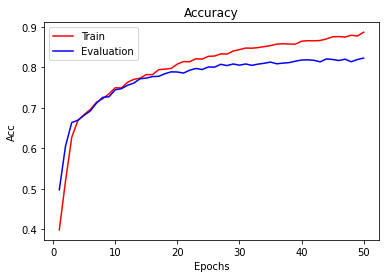

In [60]:
epochs = range(1, len(hist['train_loss']) + 1)

plt.plot(epochs, hist['train_loss'], 'r-', label='Train')
plt.plot(epochs, hist['test_loss'], 'b-', label='Evaluation')

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.plot(epochs, hist['train_acc'], 'r-', label='Train')
plt.plot(epochs, hist['test_acc'], 'b-', label='Evaluation')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

#### _*The model with pretrained vectors performs only slightly better than the original model with random initialized vectors. The reason behind that could be the small number of epochs tried on both models. In addition, the pretrained embeddings of Glove are actually based on the co-occurence of words over the internet, while our task is much more industry, or subject-specified, so some of them might not be that suitable.*_